[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bioptimus/h1-jumpstart/blob/main/H-optimus-1-tiling.ipynb)

# 🔬 Tutorial: H-optimus-1 on AWS (From Zero to Inference)

This notebook demonstrates how to deploy Bioptimus's **H-optimus-1** foundation model on AWS SageMaker and use it to encode a pathology slide on your laptop. You can run it on a free [Google Colab](https://colab.research.google.com/), or as a Jupyter notebook on your computer.

## 🛑 Prerequisites (Read This First!)
If you have never used AWS or SageMaker before, you need to set up 5 things before running this code.

### 1. Create an AWS account (The Foundation)
If you do not have an AWS account yet:
1.  Go to [aws.amazon.com](https://aws.amazon.com/) and click **Create an AWS Account**.
2.  Follow the sign-up instructions. **Note:** You will need to enter a credit card, as AWS is a paid service (though a free tier exists for some services, GPUs are usually paid).
3.  Wait for your account to be verified (usually takes a few minutes, but can take up to 24 hours).
### 2. Get AWS Access Keys (Your Login)
You need a "username" and "password" for the code to talk to AWS.
1.  Log in to your [AWS Console](https://console.aws.amazon.com/).
2.  Search for **IAM** in the top search bar.
3.  Go to **Users** -> **Create user**. Name it (e.g., `colab-user`).
4.  **Permissions:** On the permissions page, select **"Attach policies directly"**. Search for and check **`AmazonSageMakerFullAccess`**. (This gives the user permission to create endpoints).
5.  Create the user.
6.  Click on the new user's name -> go to the **Security credentials** tab.
7.  Scroll down to **Access keys** -> **Create access key**.
8.  Select **"Local code"**, acknowledge the warning, and click **Create**.
9.  **Save the `.csv` file!** You will need the `Access Key ID` and `Secret Access Key` for Step 2.

### 3. Create a SageMaker Execution Role (The Permission)
SageMaker needs its own role to run the endpoint.
1.  Go to **IAM** -> **Roles** -> **Create role**.
2.  Trusted entity: **AWS service** -> **SageMaker**.
3.  Use case: **SageMaker - Execution** -> Next.
4.  Permissions: Ensure `AmazonSageMakerFullAccess` is checked -> Next.
5.  Name it `SageMakerExecutionRole` -> Create.
6.  Click the new role and copy the **ARN**. It looks like `arn:aws:iam::123...:role/SageMakerExecutionRole`. You need this for Step 2.

### 4. Subscribe to H-optimus-1 (The Model)
You need to "buy" access to the model.
1.  Go to the [AWS Marketplace listing for H-optimus-1](https://aws.amazon.com/marketplace/pp/prodview-cuad7l27fobx4).
2.  Click **Continue to Subscribe** -> **Accept Terms**.
3.  Wait for activation -> **Continue to Configuration**.
4.  Select Region: `US East (N. Virginia)` (`us-east-1`).
5.  Copy the **Model Package ARN**. It looks like `arn:aws:sagemaker:us-east-1:865...:model-package/h-optimus-1-...`. You need this for Step 3.

### 5. Check your "Service Quota" (The Hardware)
H-optimus-1 requires a GPU. The recommended instance is **`ml.g5.xlarge`**. New AWS accounts often have a limit of "0" for this instance type.
1.  Search for **Service Quotas** in the AWS Console.
2.  Click **AWS Services** -> search for **Amazon SageMaker**.
3.  In the search bar, type `ml.g5.xlarge`.
4.  Look for **"ml.g5.xlarge for endpoint usage"**.
5.  If the "Applied quota value" is 0, click **Request increase at account-level** and ask for **1**.
    * *Note: This approval can take 1-24 hours.*

## 💻 The Code

### Step 1: Install Libraries
We need `lazyslide` (for handling huge pathology images) and `boto3` (for AWS).
After you run the following cell, you will have to restart the runtime and then directly go to the following cell.

In [ ]:
# Install Python libraries quietly and suppress all outputs
!pip install -q "sagemaker>=2.0.0,<3.0.0" boto3 lazyslide &> /dev/null
print("✅ Installation complete.")

### Step 2: AWS Login
Input the credentials you gathered in Prerequisites #1 and #2.

In [ ]:
import boto3
import sagemaker
import getpass

print("--- AWS CREDENTIALS SETUP ---")

print("\n1. Enter AWS Access Key ID:")
aws_access_key_id = getpass.getpass()

print("2. Enter AWS Secret Access Key:")
aws_secret_access_key = getpass.getpass()

print("3. Enter AWS Region (leave empty to use 'us-east-1' if unsure):")
region_name = input() or "us-east-1"

print("4. Enter SageMaker Role ARN (arn:aws:iam::...:role/...):")
role_arn = input("Role ARN: ").strip()

# Establish Connection
boto_session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region_name
)
sagemaker_session = sagemaker.Session(boto_session=boto_session)
runtime = boto_session.client("sagemaker-runtime")

print(f"✅ Connected to AWS Region: {region_name}")
print(f"✅ Using Role: {role_arn}")

### Step 3: Deploy H-optimus-1
Here you need the **Model Package ARN** from Prerequisite #3.

> **⚠️ BILLING WARNING:** Running this cell starts the hourly billing for an `ml.g5.xlarge` instance. **You MUST run the last cell (Cleanup) when you are done.**

In [ ]:
import time
from sagemaker import ModelPackage

# --- INPUT REQUIRED ---
print("Paste the ARN starting with 'arn:aws:sagemaker...' (Prerequisite #3)")
MODEL_PACKAGE_ARN = input("Enter H-optimus-1 Model Package ARN: ").strip()

# Generate a unique name for this session's endpoint
model_name = "h-optimus-1-demo"
endpoint_name = "h-optimus-1-" + time.strftime("%Y-%m-%d-%H-%M-%S")

print(f"\n🚀 Deploying model to endpoint: {endpoint_name}")
print(f"   Instance Type: ml.g5.xlarge")
print("⏳ This typically takes 5-8 minutes. Please wait...")

try:
    # 1. Define the Model
    model = ModelPackage(
        role=role_arn,
        model_package_arn=MODEL_PACKAGE_ARN,
        sagemaker_session=sagemaker_session
    )

    # 2. Deploy
    predictor = model.deploy(
        initial_instance_count=1,
        instance_type="ml.g5.xlarge",
        endpoint_name=endpoint_name,
        inference_ami_version="al2-ami-sagemaker-inference-gpu-3-1"
    )
    print("\n✅ Model Deployed and Ready! You can now send images.")

except Exception as e:
    print("\n❌ Deployment Failed! Check your Service Quotas or Role ARN.")
    print(f"Error details: {e}")

### Step 4: Load & Tile the Slide
We use `lazyslide` to detect tissue and calculate tiles at **0.5 mpp** (approx 20x magnification).

Loading slide metadata...
Detecting tissue regions...
✅ Preprocessing complete. Found 256 tiles.


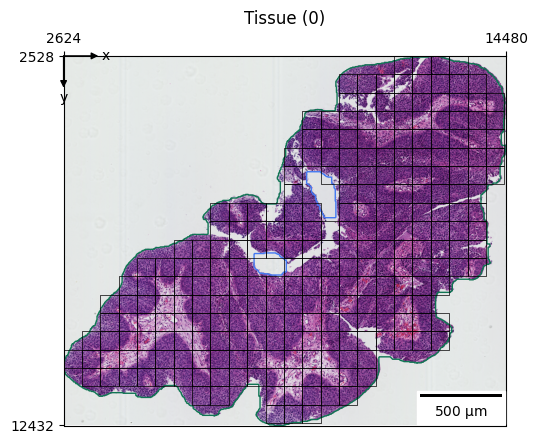

In [5]:
import warnings
import os

# Suppress Python Warnings
warnings.filterwarnings("ignore")

# Suppress Hugging Face Hub specific logs/warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

import lazyslide as zs

# 1. Load Sample Slide (Lung Carcinoma)
print("Loading slide metadata...")
wsi = zs.datasets.lung_carcinoma(with_data=False)

# 2. Detect Tissue (Segment out the white background)
print("Detecting tissue regions...")
zs.pp.find_tissues(wsi)

# 3. Create Tiles
# We request tiles of 224px at 0.5 mpp to match the model's training resolution.
zs.pp.tile_tissues(
    wsi,
    tile_px=224,
    mpp=0.5,
    overlap=0.0
)

#4. Visualize the Slide and the Tiles
zs.pl.tiles(wsi, tissue_id="all", linewidth=0.5)

num_tiles = len(wsi.shapes['tiles'])
print(f"✅ Preprocessing complete. Found {num_tiles} tiles.")

### Step 5: Test a Single Tile (The "Hello World")
Before we process thousands of tiles, let's process **just one** to make sure the model is working and the resizing logic is correct.

Sending tile #128 to H-optimus-1...
✅ Success! Received vector of length: 1536
First 5 values: [-0.891495943069458, 0.33905208110809326, 0.2214573621749878, 0.5405030846595764, 0.5777067542076111]...


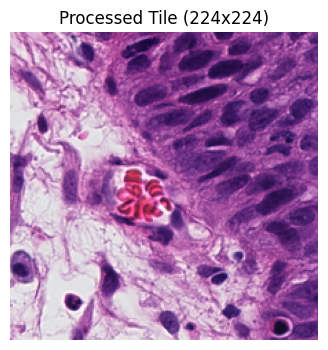

In [6]:
import io
import json
from PIL import Image
import matplotlib.pyplot as plt

# 1. Pick a tile from the middle of the list (to ensure it has tissue)
test_idx = num_tiles // 2
polygon = wsi["tiles"]["geometry"][test_idx]

# 2. Get Physical Coordinates
minx, miny, maxx, maxy = polygon.bounds
w, h = int(maxx - minx), int(maxy - miny)

# 3. Read & Resize (The Critical Step)
# Read the high-res region (e.g. 448px wide)
img_array = wsi.read_region(int(minx), int(miny), w, h)

# Convert to PIL and Resize to 224px (0.5 mpp)
img = Image.fromarray(img_array)
img = img.resize((224, 224), Image.Resampling.LANCZOS)

# 4. Send to AWS
print(f"Sending tile #{test_idx} to H-optimus-1...")
buf = io.BytesIO()
img.save(buf, format='PNG')
payload = buf.getvalue()

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="image/*",
    Accept='application/json',
    Body=payload
)

vector = json.load(response["Body"])[0]

# 5. Final Output and Visualization
print(f"✅ Success! Received vector of length: {len(vector)}")
print(f"First 5 values: {vector[:5]}...")

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Processed Tile (224x224)")
plt.axis("off")
plt.show()



### Step 6: Run Inference on All Tiles (Parallel)
Now that we know it works, we stream all the tiles to AWS using parallel threads.

In [7]:
import concurrent.futures
from tqdm import tqdm
import numpy as np

def process_single_tile(args):
    """
    Worker function: Extracts 1 tile -> Resizes -> Sends to AWS -> Returns Vector
    """
    idx, polygon = args
    try:
        # 1. Get Physical Coordinates from Polygon
        minx, miny, maxx, maxy = polygon.bounds
        w, h = int(maxx - minx), int(maxy - miny)

        # 2. Read the raw pixels (returns NumPy array)
        # We read the full resolution region
        img_array = wsi.read_region(int(minx), int(miny), w, h)

        # 3. Convert to PIL and Resize to 224x224
        # This matches the model's 0.5 mpp requirement
        img = Image.fromarray(img_array)
        img = img.resize((224, 224), Image.Resampling.LANCZOS)

        # 4. Encode via AWS
        # Convert image to bytes for transmission
        buf = io.BytesIO()
        img.save(buf, format='PNG')

        response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="image/*",
            Accept='application/json',
            Body=buf.getvalue()
        )

        # H-optimus-1 returns a list of floats
        vector = json.load(response["Body"])[0]

        # Return: Index, Geometry Info, and the Vector
        return idx, [minx, miny, w, h], vector

    except Exception as e:
        return idx, None, None

# --- Main Parallel Loop ---
print(f"Streaming {num_tiles} tiles to AWS...")

tasks = [(i, poly) for i, poly in enumerate(wsi["tiles"]["geometry"])]
results = []

# Process in parallel (8 threads)
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(
        executor.map(process_single_tile, tasks),
        total=num_tiles,
        unit="tile"
    ))

# --- Reassemble Results ---
tiles_metadata = []
final_embeddings = []

for idx, geometry, vec in sorted(results, key=lambda x: x[0]):
    if vec is not None:
        tiles_metadata.append(geometry)
        final_embeddings.append(vec)
    else:
        # Handle rare failures
        tiles_metadata.append([0, 0, 0, 0])
        final_embeddings.append(np.zeros(1536))

final_matrix = np.array(final_embeddings)
tiles_metadata = np.array(tiles_metadata)

print(f"✅ Processing Done. Feature Matrix Shape: {final_matrix.shape}")

Streaming 256 tiles to AWS...


100%|██████████| 256/256 [00:16<00:00, 15.63tile/s]

✅ Processing Done. Feature Matrix Shape: (256, 1536)


### Step 7: Visualize Feature Map (PCA)
The model converts every tile into a list of 1,536 numbers. To visualize this, we use **PCA** to compress those numbers into 3 colors (Red, Green, Blue).

* **Similar Colors** = Similar tissue structure (e.g., tumor vs. healthy).
* **Squares** = The individual tiles we processed.

Computing PCA...
Drawing feature map...


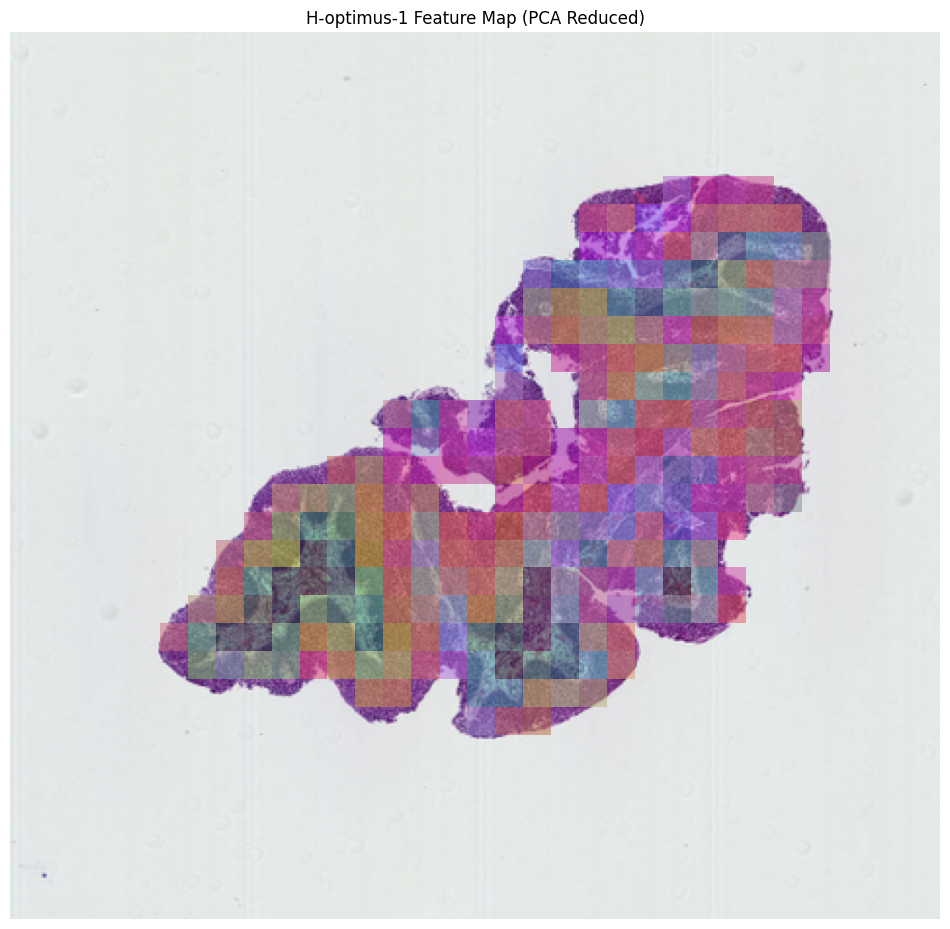

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as patches

# 1. Compute PCA (1536 dims -> 3 dims)
print("Computing PCA...")
pca = PCA(n_components=3)
pca_result = pca.fit_transform(final_matrix)

# 2. Normalize to 0-1 range (for RGB display)
scaler = MinMaxScaler()
pca_rgb = scaler.fit_transform(pca_result)

# 3. Prepare Background Thumbnail
slide_thumb = wsi.get_thumbnail()
thumb_w, thumb_h = slide_thumb.size

# Get full slide dimensions to calculate scaling ratio
level_shape = wsi.properties.level_shape
full_h, full_w = level_shape[0]
scale_factor = thumb_w / full_w

# 4. Plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(slide_thumb)

print("Drawing feature map...")
for tile_info, color in zip(tiles_metadata, pca_rgb):
    # Unpack the original coordinates (x, y, width, height)
    x, y, w, h = tile_info

    # Scale them down to fit the thumbnail
    scaled_x = x * scale_factor
    scaled_y = y * scale_factor
    scaled_w = w * scale_factor
    scaled_h = h * scale_factor

    # Draw the tile
    rect = patches.Rectangle(
        (scaled_x, scaled_y), scaled_w, scaled_h,
        linewidth=0,
        facecolor=color,
        alpha=0.5 # Transparency lets us see the tissue structure underneath
    )

    ax.add_patch(rect)

plt.axis('off')
plt.title("H-optimus-1 Feature Map (PCA Reduced)")
plt.show()

### Step 8: Cleanup (STOP BILLING)
**IMPORTANT:** You must run this cell to shut down the AWS machine. If you close the browser without running this, the meter keeps running!

In [ ]:
print(f"Deleting Endpoint: {endpoint_name}...")

# 1. Delete the Endpoint (This stops the hourly GPU billing)
try:
    sagemaker_session.delete_endpoint(endpoint_name)
    print("✅ Endpoint deleted successfully.")
except Exception as e:
    print(f"⚠️ Could not delete endpoint (or it was already deleted): {e}")

# 2. Delete the Endpoint Configuration (Good hygiene)
try:
    sagemaker_session.delete_endpoint_config(endpoint_name)
    print("✅ Endpoint Configuration deleted.")
except Exception as e:
    print(f"⚠️ Could not delete endpoint config: {e}")

# 3. Delete the Model Object (Optional, removes the registry entry)
try:
    sagemaker_session.delete_model(model_name)
    print("✅ Model registry entry deleted.")
except Exception as e:
    print(f"⚠️ Could not delete model entry: {e}")

print("\n------------------------------------------------")
print("All active resources have been cleaned up.")
print("You are no longer incurring GPU costs for this session.")

##Verification
To be 100% sure that you're not continuing to pay, you can go to the AWS Console:
1.   Search for [SageMaker](http://console.aws.amazon.com/sagemaker).
2.   On the left menu, go to **Deployment & Inference > Endpoints**.
3.   Verify that your endpoint is NOT listed there. Otherwise click on it and click 'Delete'

##Reproducibility
The cell below shows the version of the different softwares used to run this notebook successfully.

In [10]:
# --- REPRODUCIBILITY ---
# Install the watermark extension
!pip install -q watermark &> /dev/null

# Load the extension
%load_ext watermark

# Print versions of key libraries used
# -v: Python version
# -m: Machine info
# -p: Packages to list
%watermark -v -m -p boto3,sagemaker,lazyslide,openslide,PIL,numpy,sklearn,matplotlib

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 7.34.0

boto3     : 1.42.25
sagemaker : 2.256.0
lazyslide : 0.9.5
openslide : 1.4.3
PIL       : 11.3.0
numpy     : 2.0.2
sklearn   : 1.6.1
matplotlib: 3.10.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.6.105+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

